# Word2Vec

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import math
import os
import errno
import random
import zipfile

from six.moves import urllib
from six.moves import xrange
%matplotlib inline

In [0]:
data_dir = "word2Vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [0]:
def fetch_words_data(url = data_url, words_data = data_dir):
  
  #make dir if doesn't exist
  os.makedirs(words_data, exist_ok=True)
  
  #Path to zip file
  zip_path = os.path.join(words_data, "words.zip")
  
  #If the zip file isn't there, download it from the data url
  if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)
    
  #Now that the zip file is there, get the data from it
  with zipfile.ZipFile(zip_path)as f:
    data = f.read(f.namelist()[0])
  # Return a list of all the words in the data source
  return data.decode("ascii").split()

In [0]:
# Use Defaults (this make take a while!)
words = fetch_words_data()

In [5]:
# Total Words
len(words)

17005207

In [6]:
#Random Slice of words
words[9000:9020]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic']

In [7]:
for w in words[9000:9020]:
  print(w,end= ' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic 

## Build Words Counts

In [0]:
from collections import Counter

In [0]:
#demo
mylist = ["one",'one','two']

In [10]:
#demo
Counter(mylist)

Counter({'one': 2, 'two': 1})

In [11]:
Counter(mylist).most_common(1)

[('one', 2)]

## Create Word Data and Vocab

In [0]:
def create_counts(vocab_size=50000):
    
    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size)
    # Turn into a numpy array
    vocab = np.array([word for word, _ in vocab])
    
    dictionary = {word:code for code, word in enumerate(vocab)}
    
    data = np.array([dictionary.get(word,0) for word in words])
    
    return data , vocab

In [0]:
vocab_size = 50000

In [0]:
#This may take awhile
data, vocabulary = create_counts(vocab_size=vocab_size)

In [15]:
data[0]

5233

In [16]:
(words[100],data[100])

('interpretations', 4186)

In [17]:
vocabulary.shape

(50000,)

In [18]:
vocabulary[np.random.randint(0,50000)]

'hairy'

## Functions for Batches

Direct from the word2vec file from Tensorflow Docs

In [0]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [0]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [21]:
batch

array([3080, 3080, 3080, 3080, 3080, 3080, 3080, 3080], dtype=int32)

In [22]:
labels

array([[5233],
       [  11],
       [  11],
       [5233],
       [  11],
       [5233],
       [5233],
       [  11]], dtype=int32)

## Constants

In [0]:
batch_size = 128

embedding_size = 150

skip_window = 1

num_skips = 2

valid_size = 16

valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

num_sampled = 64

learning_rate = 0.01

vocabulary_size = 50000

## TensorFlow Placeholders and Constants

In [0]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

## Variables

In [0]:
#Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [0]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

## NCE LOSS

In [0]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0 /np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [0]:
loss = tf.reduce_mean(
       tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, 
                      num_sampled, vocabulary_size))

## Optimizer

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1.0)
trainer = optimizer.minimize(loss)

In [30]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis = 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# Add variable initializer 
init = tf.global_variables_initializer()

## Session

In [33]:

num_steps = 2000

with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  266.9050598144531
Average loss at step  1000 :  10063.93787361145


In [0]:
def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                xy=(x,y),
                xytext=(5,2),
                textcoords='offset points',
                ha='right',
                va='bottom')

## TSNE

Dimensionality Reduction

In [35]:
type(final_embeddings)

numpy.ndarray

In [36]:
final_embeddings.shape

(50000, 150)

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [0]:
plot_only = 2000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [0]:
labels =[vocabulary[i] for i in range(plot_only)]

In [40]:
low_dim_embs.shape

(2000, 2)

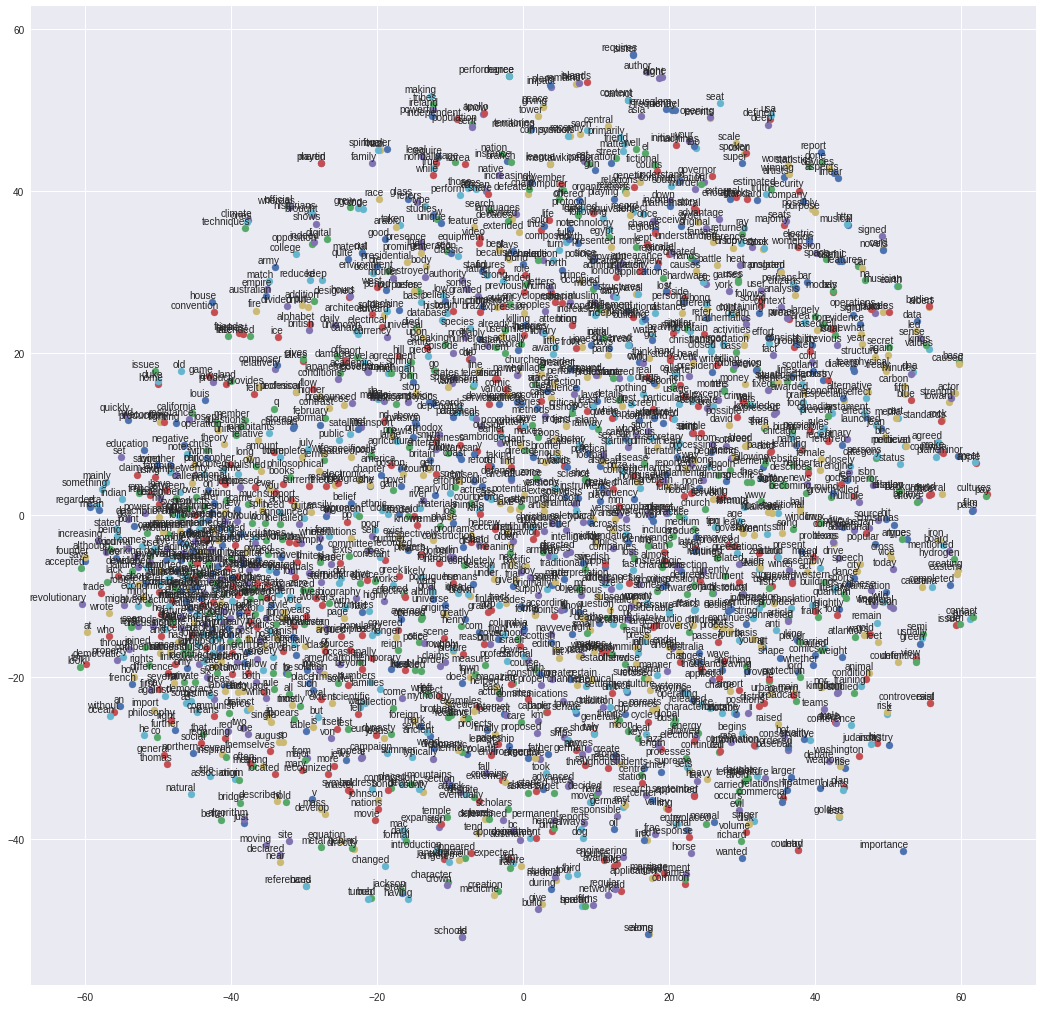

In [41]:
plot_with_labels(low_dim_embs, labels)

In [0]:
np.save('trained_embeddings',final_embeddings)

# THE END